# VAR


In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
#from pandas_datareader.data import DataReader 
from numpy import linalg as LA
%matplotlib inline

In [110]:
###Importing the data
df = pd.read_excel('Narrative_MP_Brazil_Dataset_with_Controls.xlsx', index_col=0, parse_dates=True)
#df["brlemcc"]=np.exp(df["logbrlem"])
#df["fci"]=(df["logfci"]-np.mean(df["logfci"]))*100
df["fci"]=df["logfci"]*100
df["ipca_log"] = df["ipca_log"]*100
df["pimsa_log"] = df["pimsa_log"]*100
df["logbrlem"]=df["logbrlem"]*100
df

,Selic,Selic_d,ibcbr,ibcbrsa,ibcbrsa_log,pim,pimsa,pimsa_log,pmcsa,pmcsa_log,...,fgv_ind_log,fgv_serv,fgv_serv_log,logbrlem,logfci,ff4_tc,Choque,Choque_pos,Choque_neg,fci
Data,,,,,,,,,,,,,,,,,,,,,
2003-01-31,25.50,0.0,96.15,100.38,4.608963,73.98043,79.79383,437.944618,45.79915,3.824266,...,4.650162,118.626242,4.775978,353.659911,4.612237,0.311834,0,0,0,461.223693
2003-02-28,26.50,1.0,98.67,102.07,4.625659,71.78186,79.49492,437.569312,47.05212,3.851256,...,4.664862,119.261254,4.781317,351.677057,4.608856,-0.100611,0,0,0,460.885626
2003-03-31,26.50,0.0,103.41,102.05,4.625463,77.41394,79.42228,437.477893,45.76213,3.823457,...,4.665854,119.344391,4.782013,357.190453,4.607309,0.109469,0,0,0,460.730886
2003-04-30,26.50,0.0,102.19,100.87,4.613833,76.52576,79.24657,437.256413,45.65779,3.821174,...,4.672568,119.086357,4.779849,366.901342,4.613821,0.094514,0,0,0,461.382123
2003-05-31,26.50,0.0,100.30,99.80,4.603168,79.68128,78.04771,435.732031,45.19273,3.810936,...,4.663586,118.024787,4.770895,364.994370,4.614964,0.063899,0,0,0,461.496434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,10.75,1.5,136.31,141.71,4.953783,75.87402,85.56588,444.928661,99.31007,4.598247,...,4.870017,182.783918,5.208305,362.048283,4.593053,-0.051733,0,0,0,459.305307
2022-03-31,11.75,1.0,148.42,143.22,4.964382,84.49285,86.07131,445.517614,98.57361,4.590804,...,4.892762,184.968118,5.220183,367.467403,4.593363,-0.006746,1,1,0,459.336286
2022-04-30,11.75,0.0,142.17,142.48,4.959202,80.88910,86.20807,445.676379,97.51749,4.580032,...,4.913592,183.363090,5.211468,365.205207,4.595396,0.000000,0,0,0,459.539602


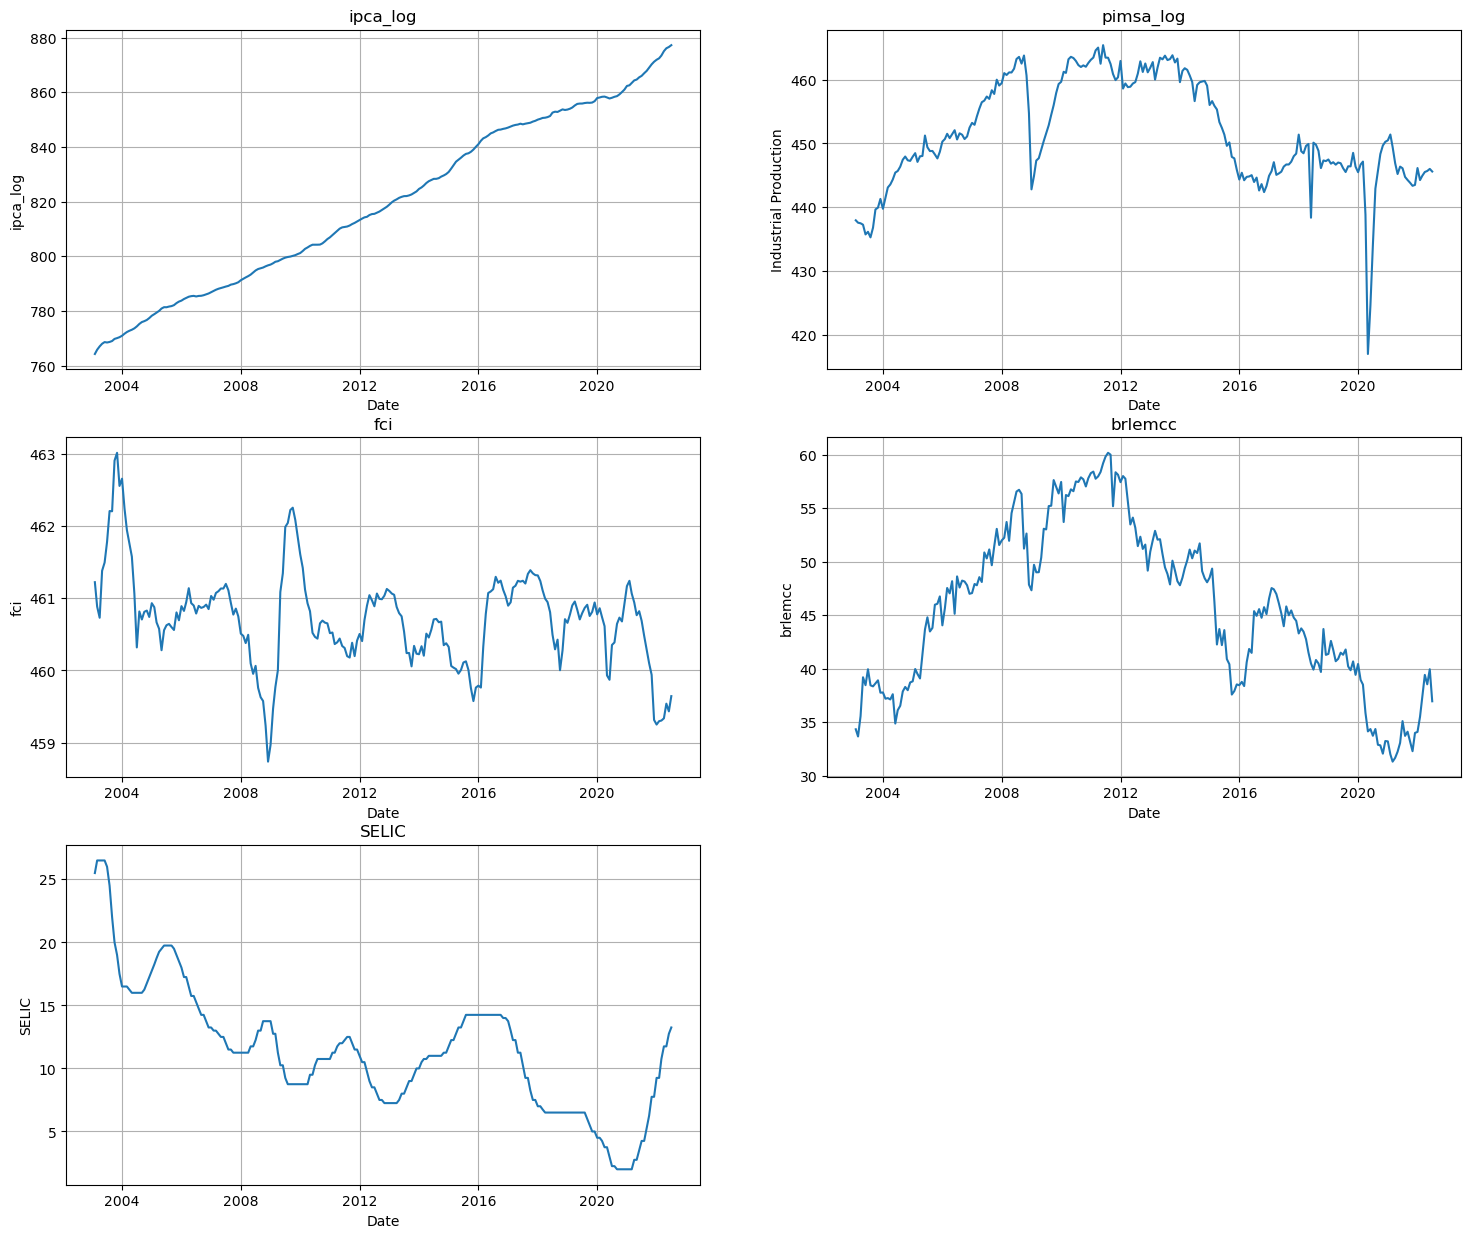

In [104]:
### taking a look at the data

plt.figure(figsize=(18,15))
plt.subplot(321)
plt.plot(df["ipca_log"])
plt.xlabel('Date')
plt.ylabel('ipca_log')
plt.title('ipca_log')
plt.grid()
plt.subplot(322)
plt.plot(df["pimsa_log"])
plt.xlabel('Date')
plt.ylabel('Industrial Production')
plt.title('pimsa_log')
plt.grid()
plt.subplot(324)
plt.plot(df["brlemcc"])
plt.xlabel('Date')
plt.ylabel('brlemcc')
plt.title('brlemcc')
plt.grid()
plt.subplot(323)
plt.plot(df["fci"])
plt.xlabel('Date')
plt.ylabel('fci')
plt.title('fci')
plt.grid()
plt.subplot(325)
plt.plot(df["Selic"])
plt.xlabel('Date')
plt.ylabel('SELIC')
plt.title('SELIC')
plt.grid()
plt.show()


### We have the data, now we need to define a class, so that it can estimate the parameters of the model with our data, identify the structural shocks and create impulse response functions.

In [105]:
class SVAR():
    def __init__(self, X, lags=2, num_impulses = 100):  
        self.X = X
        self.num_vars = X.shape[1]
        self.num_obs = X.shape[0]
        self.lags = lags                 
        self.num_impulses = num_impulses 
        
    def Xlags(self):  # We need to create a dataframe with lags of our variables to use as dependent variables in the VAR model.
        XLAG = pd.DataFrame()
        for l in range(1,self.lags+1):
            XLAG = pd.concat([XLAG, self.X.shift(l).add_suffix("-"+str(l))], axis=1)
        X_avlb_dta = X.iloc[self.lags:,:]
        XLAG_avlb_dta = XLAG.iloc[self.lags:,:]  # Now we need to exclude from X and XLAG the observations where we have no data available for the lags.
        Xa = np.array(X_avlb_dta)                # And transform them in arrays so later we can perform math/algebra operations with them
        XLAGa = np.array(XLAG_avlb_dta)
        return Xa, XLAGa
    
    def ols_fit(self):   # Here, we use ols to estimate our VAR (reduced form) and recover the coefficients, rediduals and the error variance-covariance matrix
        Xa, XLAGa = self.Xlags()
        Bhat = inv(XLAGa.T@XLAGa)@XLAGa.T@Xa
        U = (Xa-XLAGa@Bhat)
        Ωhat = U.T@U
        return Bhat, U, Ωhat
    
    def identification(self):
        _, U, Ωhat = self.ols_fit()
        C = LA.cholesky(Ωhat)  # Use a cholesky decomposition to obtain a matrix that will be used to identify the structural shocks
        d = np.zeros(C.shape)  # Normalizing the matrix C
        np.fill_diagonal(d, np.diag(C))
        C = np.dot(np.linalg.inv(d), C)
        Ε = U @ inv(C).T   #Multiplying reduced form shocks by inv(C) to obtain the structural shocks Ε.
        return C, Ε
    
    def IRF(self):
        Xa, _ = self.Xlags()
        Bhat, _, _ = self.ols_fit()
        C, _ = self.identification()
        c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((self.lags-1)*self.num_vars), # Create a canonical form of Bhat to work as this was a VAR(1) (easier to represent as MA)
                                      np.zeros([(self.lags-1)*self.num_vars,self.num_vars]))))) 
        IRF  = np.zeros([self.num_impulses,self.num_vars,self.num_vars])
        Temp = np.identity(c_Bhat.shape[0]) # Initialize an array to store the IRF and a temp matrix, that represents the coefficients of the reduced form moving average
        for t in range(self.num_impulses):
            ψ_t = Temp[:self.num_vars,:self.num_vars] 
            IRF[t,:,:] = ψ_t @ C # Multiply the coefficients of the reduced form MA by C to obtain the coefficients of the structural form, which gives us our impulse response functions
            Temp = c_Bhat @ Temp # Update Temp to give us this sequence: (I, c_Bhat, (c_Bhat)^2, (c_Bhat)^3,...)
        irf  = pd.DataFrame({i:IRF[i].flatten() for i in range(self.num_impulses)}).T #save IRFs into a dataframe, flattening to two dimensions.
                
        
        irf.columns = ["Ε_IP>IP","Ε_IPCA>IP","Ε_IFIN>IP","Ε_BRL>IP","Ε_SELIC>IP","Ε_IPC>IPCA","Ε_IPCA>IPCA","Ε_IFIN>IPCA","Ε_BRL>IPCA","Ε_SELIC>IPCA","Ε_IP>IFIN","Ε_IPCA>IFIN","Ε_IFIN>IFIN","Ε_BRL>IFIN","Ε_SELIC>IFIN","Ε_IP>BRL","Ε_IPCA>BRL","Ε_IFIN>BRL","Ε_BRL>BRL","Ε_SELIC>BRL","Ε_IP>SELIC","Ε_IPCA>SELIC","Ε_IFIN>SELIC","Ε_BRL>SELIC","Ε_SELIC>SELIC"]
        
        return c_Bhat, irf

### Then, we can use our data to define an instance of the class, call the methods on this instance and check the results

In [111]:
X = df[["pimsa_log", "ipca_log", "fci", "logbrlem","Selic"]]
Model1 = SVAR(X)
Xa, _ = Model1.Xlags()
Bhat, U, Ωhat = Model1.ols_fit()
C, Ε = Model1.identification()
C

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.23085991,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.12620925,  0.00394021,  1.        ,  0.        ,  0.        ],
       [ 0.18065561, -0.04479011,  0.14345695,  1.        ,  0.        ],
       [ 0.03505935,  0.06454535, -0.20365296,  0.10994609,  1.        ]])

In [112]:
_, irf = Model1.IRF()
irf[["Ε_SELIC>IPCA","Ε_SELIC>IP","Ε_SELIC>BRL","Ε_SELIC>IFIN","Ε_SELIC>SELIC"]]

,Ε_SELIC>IPCA,Ε_SELIC>IP,Ε_SELIC>BRL,Ε_SELIC>IFIN,Ε_SELIC>SELIC
0,0.000000,0.000000,0.000000,0.000000,1.000000
1,-0.001522,0.254669,0.817698,-0.110741,1.246100
2,0.005044,0.141554,0.608714,-0.119662,1.348025
3,0.013044,-0.163659,0.710170,-0.124348,1.367895
4,0.021059,-0.418810,0.693643,-0.110376,1.364446
...,...,...,...,...,...
95,-0.499374,0.360175,0.567196,0.157656,0.037220
96,-0.500210,0.359520,0.566448,0.156761,0.037096
97,-0.501040,0.358827,0.565694,0.155862,0.036989
98,-0.501865,0.358098,0.564936,0.154962,0.036898


### Now that we have our impulse response functions, we can plot them

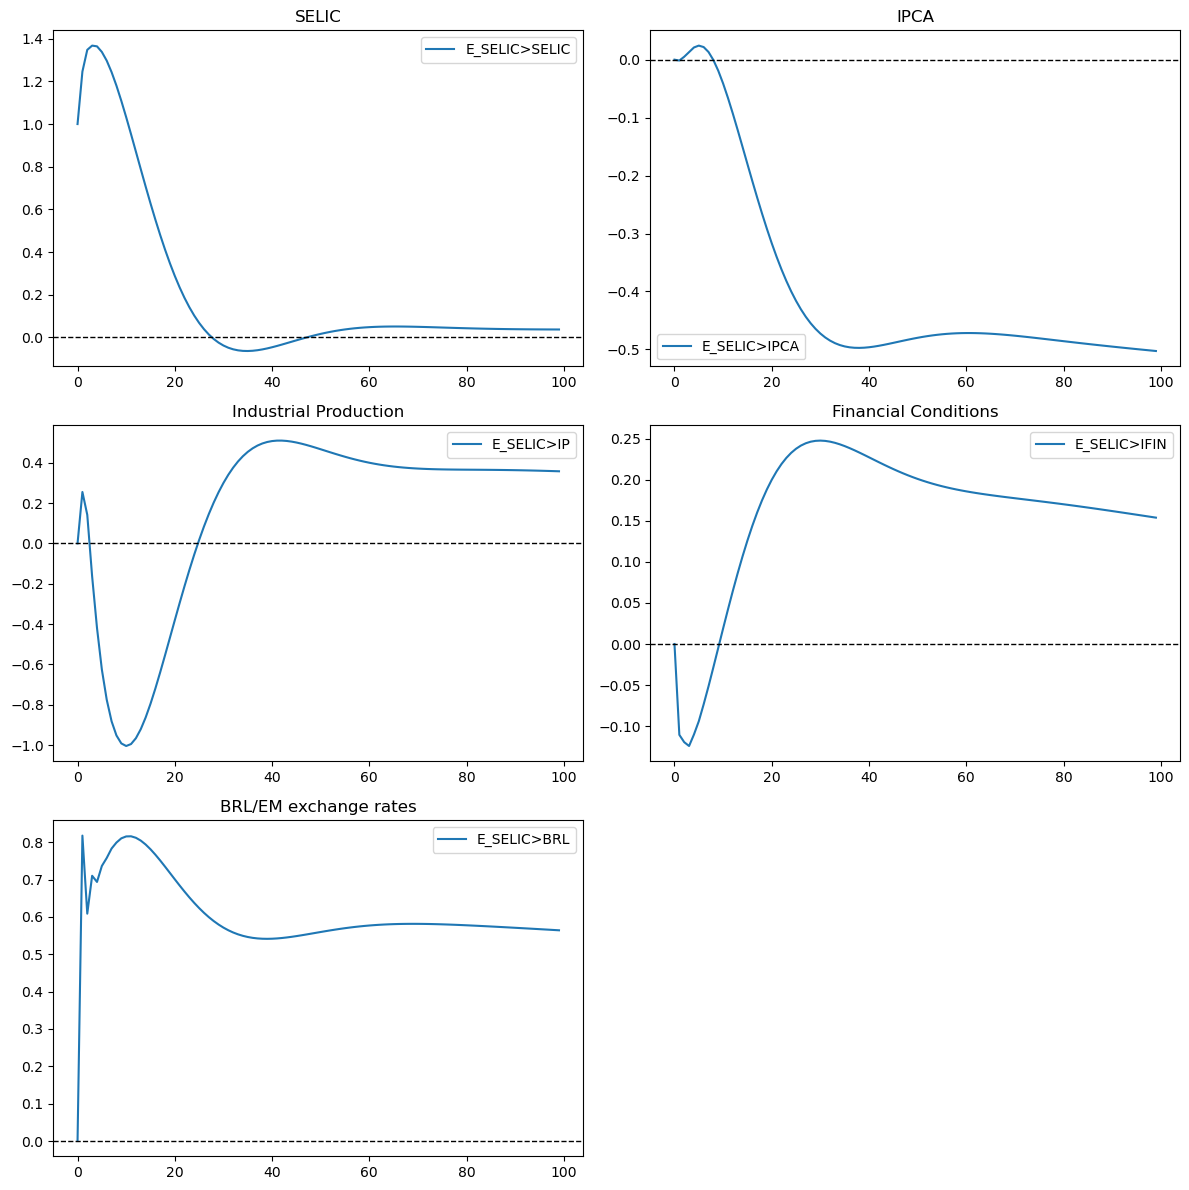

In [113]:

# Supondo que 'irf' é o nome do seu DataFrame
columns_to_plot = ["Ε_SELIC>SELIC","Ε_SELIC>IPCA", "Ε_SELIC>IP", "Ε_SELIC>IFIN", "Ε_SELIC>BRL"]

# Criando subgráficos para cada coluna
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Iterando sobre as colunas e criando gráficos
for i, column in enumerate(columns_to_plot):
    row = i // 2  # Determina a linha
    col = i % 2   # Determina a coluna
    axs[row, col].plot(irf.index, irf[column], label=column)
    axs[row, col].set_title(column)
    axs[row, col].legend()
    


# Removendo o último eixo (espaço vazio)
fig.delaxes(axs[2, 1])

# Adicionando linha no zero para todos os subgráficos
for ax in axs.flat:
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Ajustando layout
plt.tight_layout()

axs[0, 0].set_title('SELIC')
axs[0, 1].set_title('IPCA')
axs[1, 0].set_title('Industrial Production')
axs[1, 1].set_title('Financial Conditions')
axs[2, 0].set_title('BRL/EM exchange rates')



# Exibindo os gráficos
plt.show()


In [102]:
subset_data = irf

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)